<a href="https://colab.research.google.com/github/PanavShah1/deep_learning_projects/blob/main/Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Data

In [1]:
# Import libraries
import requests
from pathlib import Path
import zipfile
import os

# Create data and reviews directory
data_path = Path("data/")
reviews_path = data_path / "reviews"
if reviews_path.is_dir():
  print("Reviews directory already exists")
else:
  os.makedirs(reviews_path)
  print("Reviews directory created")

  #Get the zip file
  with open(data_path / "reviews.zip", "wb") as zip:
    request = requests.get("https://github.com/PanavShah1/dogs_cats/blob/main/test.ft.txt.bz2.zip?raw=true")
    zip.write(request.content)
    print("Zip file downloaded")

  # Unzip the file
  with zipfile.ZipFile(data_path / "reviews.zip", "r") as zip:
    zip.extractall(reviews_path)
    print("Zip file extracted")

Reviews directory already exists


## Setup device agnostic code

In [2]:
import torch
torch.__version__

'2.3.0+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Analyse data

In [4]:
import bz2
reviews_file = reviews_path / "test.ft.txt.bz2"
source_file = bz2.open(reviews_file, "r")
count = 0
for line in source_file:
  count += 1
  print(count, line)
  if count == 10:
    break

1 b'__label__2 Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"\n'
2 b"__label__2 One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not t

In [5]:
line = next(iter(source_file))
line

b'__label__2 Great book for travelling Europe: I currently live in Europe, and this is the book I recommend for my visitors. It covers many countries, colour pictures, and is a nice starter for before you go, and once you are there.\n'

In [6]:
line = str(line.strip())
line

"b'__label__2 Great book for travelling Europe: I currently live in Europe, and this is the book I recommend for my visitors. It covers many countries, colour pictures, and is a nice starter for before you go, and once you are there.'"

In [7]:
start = line[:12].split("b'")[1]
end = line[13:].split("\\n")[0]
start, end

('__label__2',
 "Great book for travelling Europe: I currently live in Europe, and this is the book I recommend for my visitors. It covers many countries, colour pictures, and is a nice starter for before you go, and once you are there.'")

In [8]:
def convert_data(line):
  line_string = str(line.strip())
  index = line_string.find("b")

  start = line_string[:12][index+2:]
  end = line_string[13:].split("\\n")[0]
  return start, end

In [9]:
temp_line = next(iter(source_file))
temp_line

b'__label__1 Not!: If you want to listen to El Duke , then it is better if you have access to his shower,this is not him, it is a gimmick,very well orchestrated.\n'

In [10]:
convert_data(temp_line)

('__label__1',
 "Not!: If you want to listen to El Duke , then it is better if you have access to his shower,this is not him, it is a gimmick,very well orchestrated.'")

In [11]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer("basic_english")
reviews = ["This product is great!", "Terrible product, would not buy again."]
ratings = [1, 0]
tokenized_reviews = [tokenizer(review) for review in reviews]
tokenized_reviews

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

[['this', 'product', 'is', 'great', '!'],
 ['terrible', 'product', ',', 'would', 'not', 'buy', 'again', '.']]

In [12]:
vocab = build_vocab_from_iterator(tokenized_reviews, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
vocab.get_stoi()

{'terrible': 10,
 'would': 12,
 'not': 9,
 'buy': 6,
 'this': 11,
 'again': 5,
 '.': 4,
 'great': 7,
 ',': 3,
 'is': 8,
 '!': 2,
 'product': 1,
 '<unk>': 0}

In [13]:
indices_reviews = [torch.tensor([vocab[token] for token in review]) for review in tokenized_reviews]
indices_reviews

[tensor([11,  1,  8,  7,  2]), tensor([10,  1,  3, 12,  9,  6,  5,  4])]

In [14]:
from torch.nn.utils.rnn import pad_sequence

padded_reviews = pad_sequence(indices_reviews, batch_first=True)
padded_reviews

tensor([[11,  1,  8,  7,  2,  0,  0,  0],
        [10,  1,  3, 12,  9,  6,  5,  4]])

In [15]:
from tqdm.auto import tqdm
def create_database(source_file):
  X = []
  y = []
  for line in tqdm(source_file):
    # print("line")
    start, end = convert_data(line)
    X.append(end)
    y.append(start)
  return X, y

In [16]:
database = create_database(source_file)

0it [00:00, ?it/s]

In [17]:
database[0][0]

'A complete Bust: This game requires quicktime 5.0 to work...if you have a better version of quicktime (I have 7.5), it will ask you to install the quicktime available on the CD...if you click no, it will not let you play. So, I begrudgingly clicked yes on the third try, and it installed quicktime 5, THEN it tells me to please install the quicktime available on the disc. It KEPT telling me that, even after I uninstalled my version of quicktime 7.5, and reinstalled Barbie Rapunzel and quicktime 5. Very frustrating, and the game absolutely will not work for me. It keeps telling me over and over, to install quicktime 5, tho I\\\'ve been through the installation process repeatedly. It is NOT my "operating system limitations". This is a brand new computer...merely weeks old with all the state of the art contraptions.\''

In [18]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer("basic_english")
# reviews = ["This product is great!", "Terrible product, would not buy again."]
# ratings = [1, 0]
tokenized_reviews = [tokenizer(review) for review in tqdm(database[0])]
tokenized_reviews

vocab = build_vocab_from_iterator(tokenized_reviews, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

indices_reviews = [torch.tensor([vocab[token] for token in review]) for review in tokenized_reviews]

from torch.nn.utils.rnn import pad_sequence

padded_reviews = pad_sequence(indices_reviews, batch_first=True)


  0%|          | 0/399988 [00:00<?, ?it/s]

In [19]:
for i, review in enumerate(database[1]):
  if review == "__label__1":
    database[1][i] = 0
  else:
    database[1][i] = 1

In [20]:
database[1][:10]

[0, 1, 0, 0, 1, 1, 1, 1, 0, 0]

In [21]:
padded_reviews[:10]

tensor([[   7,  483, 6585,  ...,    0,    0,    0],
        [ 476,  139,    7,  ...,    0,    0,    0],
        [ 179,    6,   25,  ...,    0,    0,    0],
        ...,
        [  72,   10,    2,  ...,    0,    0,    0],
        [ 180,    5,  310,  ...,    0,    0,    0],
        [ 527,   39,    9,  ...,    0,    0,    0]])

In [22]:
padded_reviews[0].shape

torch.Size([661])

In [23]:
padded_reviews[0]

tensor([    7,   483,  6585,    11,   152,  2062, 19686,   228,     1,  1235,
            8,   102,     1,     1,     1,    34,    17,    27,     7,    98,
          261,    10, 19686,    41,     4,    27,   748,     1,   228,    40,
            3,     9,    56,  1079,    17,     8,   971,     2, 19686,   576,
           23,     2,   101,     1,     1,     1,    34,    17,  2684,    61,
            3,     9,    56,    19,   340,    17,   251,     1,    32,     3,
            4, 42574,  8996,   540,    23,     2,   802,   266,     3,     5,
            9,  1246, 19686,   228,     3,   110,     9,  1080,    51,     8,
          426,   971,     2, 19686,   576,    23,     2,   571,     1,     9,
          588,  1274,    51,    16,     3,    82,    84,     4, 10963,    26,
          261,    10, 19686,   748,     1,   228,     3,     5, 13148,  4585,
        22562,     5, 19686,   228,     1,    36,  1520,     3,     5,     2,
          152,   447,    56,    19,   102,    15,    51,     1, 

In [24]:
max = torch.tensor(0)
for padded_review in padded_reviews:
  if padded_review.max() > max:
    max = padded_review.max()
max

tensor(368660)

## Create test train split

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_reviews, torch.tensor(database[1]), test_size=0.2, random_state=42)

In [26]:
len(X_train), len(X_test), len(y_train), len(y_test)

(319990, 79998, 319990, 79998)

In [27]:
X_train[:10], y_train[:10]

(tensor([[ 3082,    11,   169,  ...,     0,     0,     0],
         [  221,   378,    42,  ...,     0,     0,     0],
         [91931,   426,  2658,  ...,     0,     0,     0],
         ...,
         [ 7023,  5970,    19,  ...,     0,     0,     0],
         [ 7598,   494,    26,  ...,     0,     0,     0],
         [   17,   137,    44,  ...,     0,     0,     0]]),
 tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 0]))

## Setup Dataset and Dataloader

In [28]:
from torch.utils.data import Dataset

class ReviewsDataset(Dataset):
  def __init__(self, reviews, ratings):
    self.reviews = reviews / max
    self.ratings = ratings
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, idx):
    review = self.reviews[idx]
    rating = self.ratings[idx]
    return review, rating

train_dataset = ReviewsDataset(X_train, y_train)
test_dataset = ReviewsDataset(X_test, y_test)

In [29]:
train_dataset[:5]

(tensor([[8.3600e-03, 2.9838e-05, 4.5842e-04,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [5.9947e-04, 1.0253e-03, 1.1393e-04,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.4937e-01, 1.1555e-03, 7.2099e-03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [3.9874e-04, 1.3861e-03, 1.1393e-04,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.7143e-03, 2.4684e-04, 1.4376e-04,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([0, 1, 0, 1, 1]))

In [30]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=True)

In [31]:
temp_dataloader = next(iter(train_dataloader))
temp_dataloader

[tensor([[2.4719e-02, 1.8988e-05, 6.5236e-03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.2456e-02, 1.2494e-02, 3.5263e-05,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0308e-04, 3.1465e-04, 9.7651e-05,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [3.6239e-03, 2.9838e-05, 1.0145e-03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [5.2894e-04, 6.2931e-04, 3.7975e-05,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [3.0380e-04, 2.1700e-05, 5.5962e-02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 1, 1])]

In [32]:
train_reviews, train_ratings = temp_dataloader
train_reviews.shape, train_ratings.shape

(torch.Size([32, 661]), torch.Size([32]))

## ModelV0 (Linear Regression)

In [33]:
from torch import nn

class ModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_layers: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_shape,
                  out_features=hidden_layers),
        nn.Linear(in_features=hidden_layers,
                  out_features=hidden_layers),
        nn.Linear(in_features=hidden_layers,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

model_0 = ModelV0(input_shape=661,
                  hidden_layers=10,
                  output_shape=2).to(device)

In [34]:
X_temp = padded_reviews[0]
X_temp.shape

torch.Size([661])

In [35]:
model_0

ModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=661, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [36]:
pred_temp = model_0(X_temp.type(torch.float32).to(device))
pred_temp

tensor([ 24.3968, 223.4220], device='cuda:0', grad_fn=<ViewBackward0>)

## Create train and test loop functions

In [37]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    X = X.type(torch.float32)
    # print(X.shape, y.shape)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    # print(loss)
    train_loss += loss.item()
    # print(train_loss)
    # if torch.isnan(loss):
    #   break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [38]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      X = X.type(torch.float32)

      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += (y_pred_class == y).sum().item() / len(y_pred)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [39]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               test_dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               epochs: int,
               device=device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                      dataloader=train_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    print(f"Epochs: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}")

  return results

In [40]:
# Plot train and test loss and accuracy
import matplotlib.pyplot as plt
def plot(results):
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.plot(results["train_loss"], label="Train loss")
  plt.plot(results["test_loss"], label="Test loss")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(results["train_acc"], label="Train acc")
  plt.plot(results["test_acc"], label="Test acc")
  plt.legend()
  plt.show()

In [41]:
def compare(result0, result1):
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.plot(result0["train_loss"], label="Train loss 0")
  plt.plot(result0["test_loss"], label="Test loss 0")
  plt.plot(result1["train_loss"], label="Train loss 1")
  plt.plot(result1["test_loss"], label="Test loss 1")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(result0["train_acc"], label="Train acc 0")
  plt.plot(result0["test_acc"], label="Test acc 0")
  plt.plot(result1["train_acc"], label="Train acc 1")
  plt.plot(result1["test_acc"], label="Test acc 1")
  plt.legend()
  plt.show()

## Train and evaluate model_0

In [42]:
model_0 = ModelV0(input_shape=661,
                  hidden_layers=10,
                  output_shape=2).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.01)


results_model_0 = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=7)

  0%|          | 0/7 [00:00<?, ?it/s]

Epochs: 0 | Train loss: 0.693 | Train acc: 0.503 | Test loss: 0.693 | Test acc: 0.503
Epochs: 1 | Train loss: 0.693 | Train acc: 0.505 | Test loss: 0.693 | Test acc: 0.500
Epochs: 2 | Train loss: 0.693 | Train acc: 0.507 | Test loss: 0.693 | Test acc: 0.509
Epochs: 3 | Train loss: 0.693 | Train acc: 0.510 | Test loss: 0.693 | Test acc: 0.503
Epochs: 4 | Train loss: 0.692 | Train acc: 0.514 | Test loss: 0.692 | Test acc: 0.516
Epochs: 5 | Train loss: 0.692 | Train acc: 0.515 | Test loss: 0.692 | Test acc: 0.516
Epochs: 6 | Train loss: 0.692 | Train acc: 0.517 | Test loss: 0.693 | Test acc: 0.511


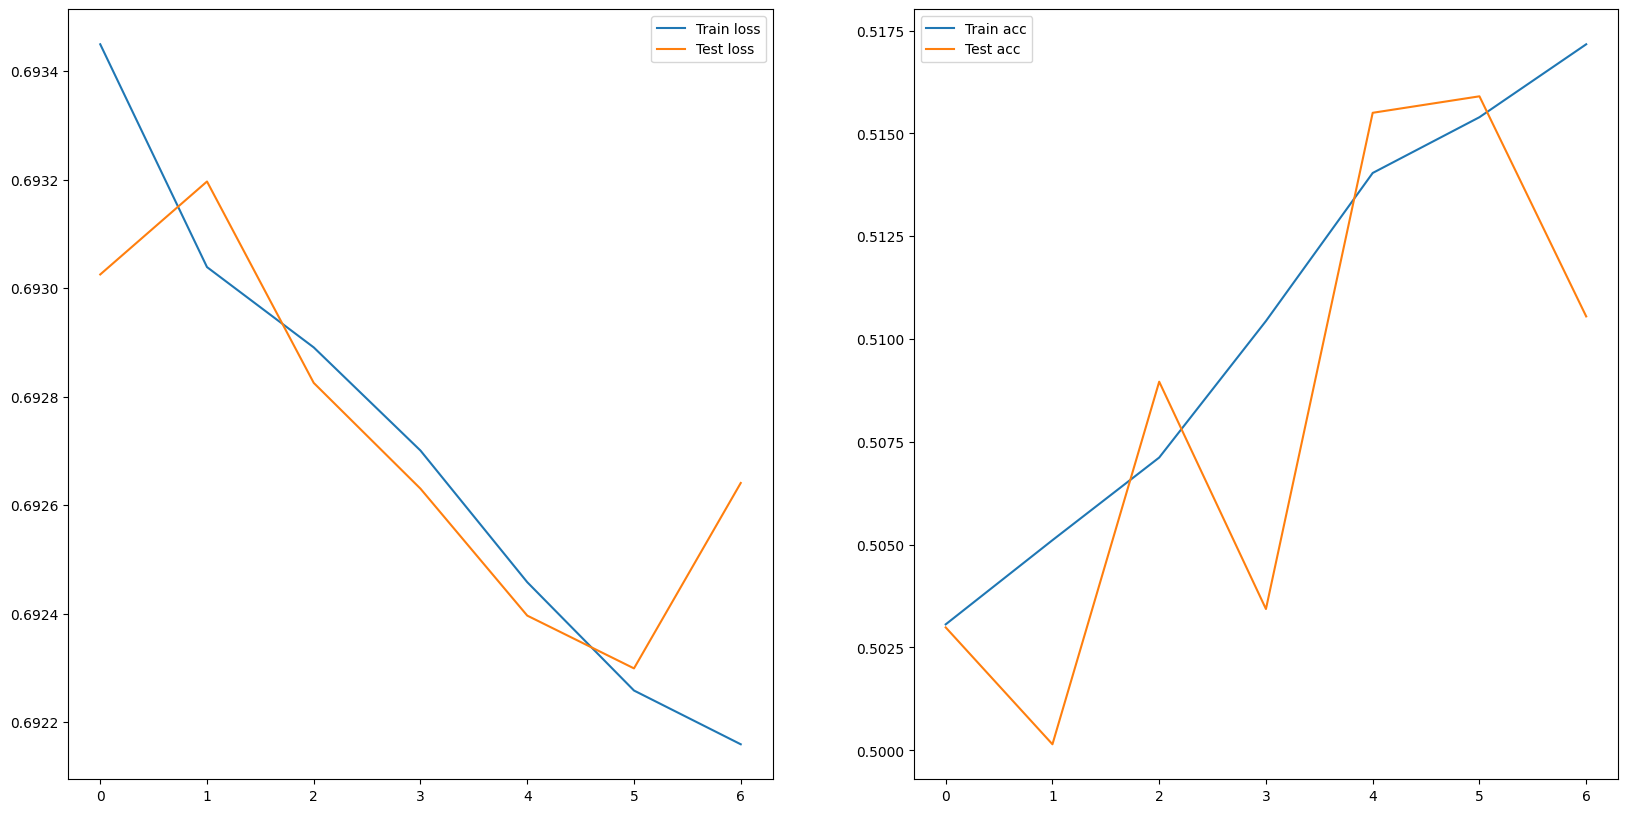

In [43]:
plot(results_model_0)

## ModelV1 (ReLU)

In [44]:
from torch import nn

class ModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_layers: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_shape,
                  out_features=hidden_layers),
        nn.ReLU(),
        nn.Linear(in_features=hidden_layers,
                  out_features=hidden_layers),
        nn.ReLU(),
        nn.Linear(in_features=hidden_layers,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)


In [45]:
model_1 = ModelV1(input_shape=661,
                  hidden_layers=10,
                  output_shape=2).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.01)


results_model_1 = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=7)

  0%|          | 0/7 [00:00<?, ?it/s]

Epochs: 0 | Train loss: 0.693 | Train acc: 0.501 | Test loss: 0.693 | Test acc: 0.502
Epochs: 1 | Train loss: 0.693 | Train acc: 0.503 | Test loss: 0.693 | Test acc: 0.503
Epochs: 2 | Train loss: 0.693 | Train acc: 0.505 | Test loss: 0.693 | Test acc: 0.506
Epochs: 3 | Train loss: 0.693 | Train acc: 0.507 | Test loss: 0.693 | Test acc: 0.503
Epochs: 4 | Train loss: 0.693 | Train acc: 0.509 | Test loss: 0.693 | Test acc: 0.503
Epochs: 5 | Train loss: 0.693 | Train acc: 0.511 | Test loss: 0.693 | Test acc: 0.513
Epochs: 6 | Train loss: 0.693 | Train acc: 0.513 | Test loss: 0.693 | Test acc: 0.511


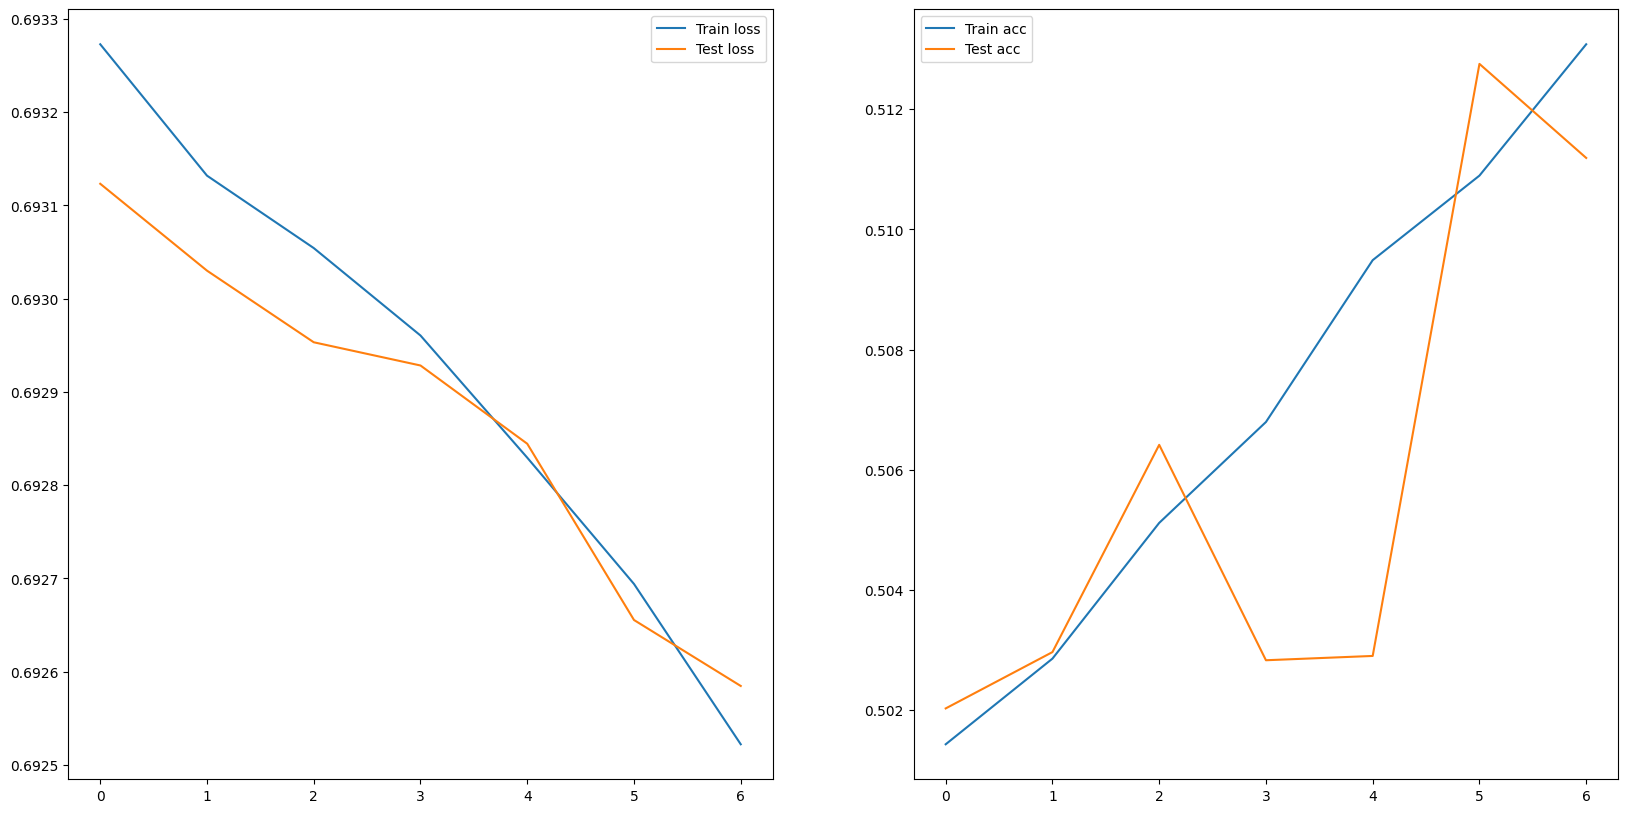

In [46]:
plot(results_model_1)

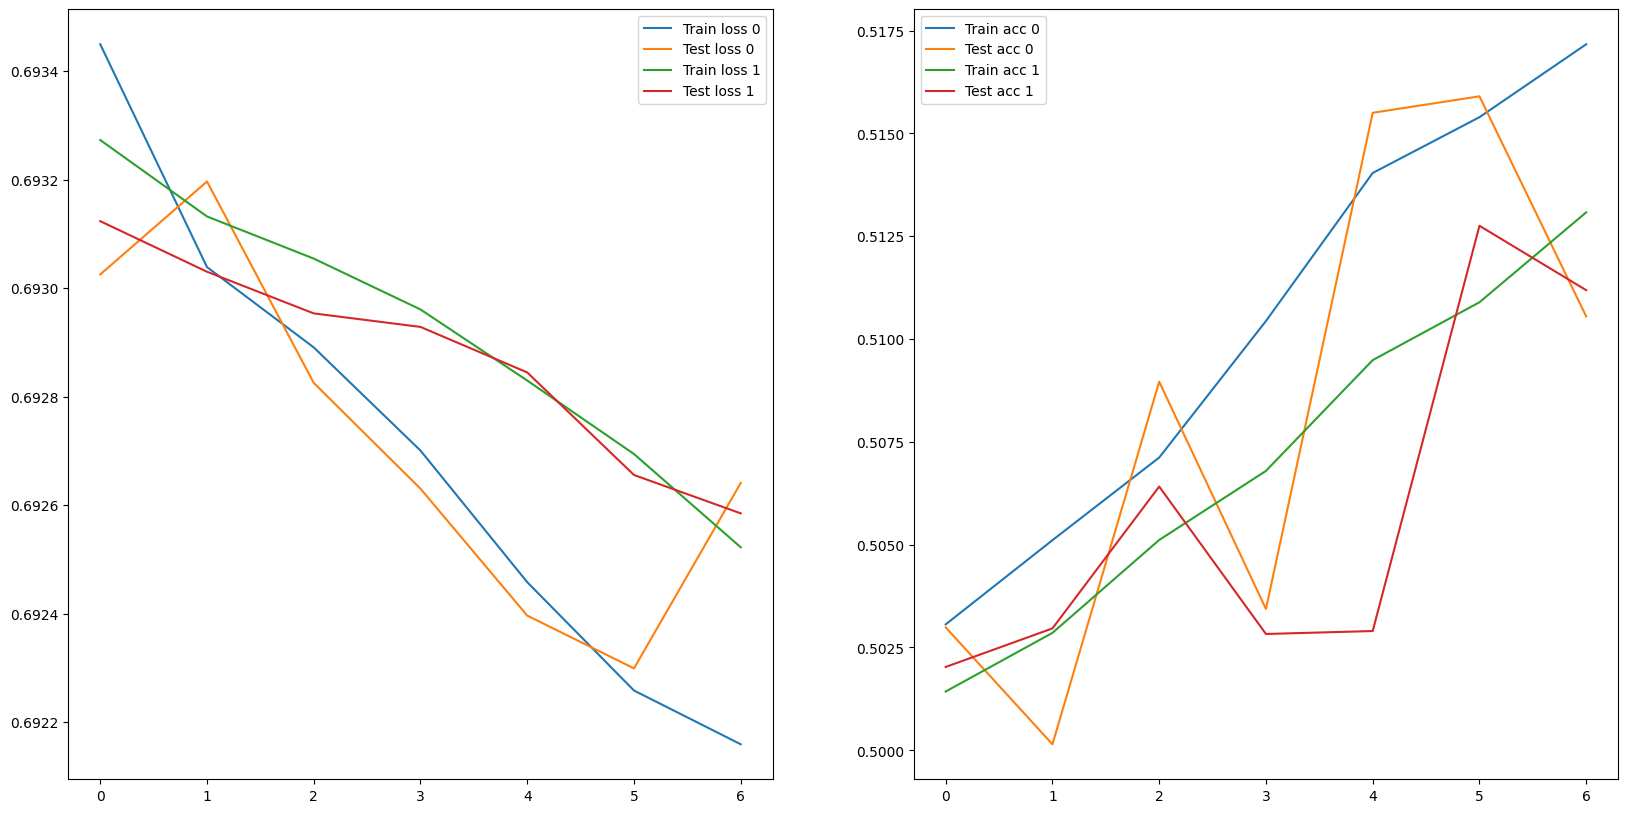

In [47]:
compare(results_model_0, results_model_1)

## Increasing the learning rate in ModelV0

In [ ]:
model_2 = ModelV0(input_shape=661,
                  hidden_layers=10,
                  output_shape=2).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.1)


results_model_2 = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=7)

In [ ]:
compare(results_model_0, results_model_2)

## Decrease the learning rate in ModelV0

In [ ]:
model_3 = ModelV0(input_shape=661,
                  hidden_layers=10,
                  output_shape=2).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.001)


results_model_3 = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=7)

In [ ]:
compare(results_model_0, results_model_3)

## ModelV4 (Embedding, LSTM)

In [ ]:
class ModelV4(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return self.softmax(out)
         # Output dimensions (good or bad)

# Instantiate the model
model_4 = ModelV4(661, 128, 128, 2)


In [ ]:
model_4 = ModelV4(661, 128, 128, 2).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(),
                            lr=0.001)


results_model_4 = train(model=model_4,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=7)